In [1]:
# downloaded: ipykernel, jupyterlab, notebook, scipy, requests, pytz, seaborn, plotly, h5py
# Core libraries
import os, time, gc, itertools, pickle, psutil
from collections import OrderedDict, defaultdict
from tqdm import tqdm
# Scientific and Data libraries
import numpy as np, pandas as pd
from scipy.stats import fisher_exact, ttest_1samp, norm
# Plotting libraries
import seaborn as sns, matplotlib.pyplot as plt
import plotly.express as px, plotly.graph_objs as go, plotly.offline as py
# Bioinformatics libraries
from Bio.Seq import Seq
from Bio import SeqIO
from skbio.alignment import StripedSmithWaterman
import pybedtools, logomaker
pybedtools.set_bedtools_path("/opt/packages/bedtools/2.30.0") #### Required so that it can find the bedtools executable
# PyTorch libraries
import torch
import torch.nn.functional as F
# Multiprocessing
from multiprocessing import Pool, cpu_count
# h5py for handling HDF5 files
import h5py

In [2]:
%config Completer.use_jedi = False
%matplotlib inline
# %matplotlib notebook
py.init_notebook_mode(connected=True)
# %matplotlib widget


# Functions

In [3]:
def seq2tensor(seq):
    """
    Converts a DNA sequence string to a tensor containing only 01234 (ACGTN).

    Args:
    - seq (str): DNA sequence

    Returns:
    - tensor: containing only 01234 (ACGTN)
    """
    # Convert sequence to uppercase
    seq_out = seq.upper()

    # Define allowed DNA characters
    allowed = set("ACTGN")

    # Replace invalid characters with 'N'
    if not set(seq_out).issubset(allowed):
        invalid = set(seq_out) - allowed
        seq_out = seq_out.translate(str.maketrans("".join(list(invalid)), 'N' * len(invalid)))

    # Map DNA characters to numerical values
    seq_out = seq_out.translate(str.maketrans('ACGTN', '01234'))

    # Convert sequence to tensor
    return torch.from_numpy(np.asarray(list(seq_out), dtype='int'))

def get_reverse_complement(seq):
    """
    Get the reverse complement of a DNA sequence.

    Args:
    seq (str): The DNA sequence.

    Returns:
    str: The reverse complement of the input DNA sequence.
    """
    seq = seq.upper()
    # Use translate to get the reverse complement and then reverse the result
    return seq.translate(str.maketrans('ATCG', 'TAGC'))[::-1]

def get_random_seq(size):
    """
    Generate a random DNA sequence of a given size.

    Args:
    size (int): The length of the DNA sequence to generate.

    Returns:
    str: The randomly generated DNA sequence.
    """
    bases = list('ATCG')  # List of DNA bases
    random_seq = ''.join(np.random.choice(bases, size))  # Generate random sequence
    return random_seq

def one_hot4seqs(list_seq):
    """
    Encode a list of DNA sequences into a one-hot matrix.

    Args:
    list_seq (list): List of DNA sequences to encode

    Returns:
    torch.Tensor: One-hot matrix of shape (N, 4, seq_length)
    """
    # Convert each sequence to tensor and uppercase
    list_seq_out = []
    for i in range(len(list_seq)):
        list_seq_out.append(seq2tensor(list_seq[i].upper()))

    # Stack the tensors, apply one-hot encoding, and permute the dimensions
    return F.one_hot(torch.stack(list_seq_out),
                     num_classes=5).permute((0, 2, 1))[:, :-1, :]

def read_fasta(fasta_file):
    dic_fasta = OrderedDict()
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if line.startswith('>'):
                seq_name = line.strip().split(' ')[0][1:]
                dic_fasta[seq_name] = ''
            else:
                dic_fasta[seq_name] += line.strip()
    return dic_fasta

def get_bed_peak_sequence(bed_file, genome_sequence_fa, return_seq_name=False):
    pybed = pybedtools.BedTool(bed_file)
    pybed = pybed.sequence(fi=genome_sequence_fa, s=True)
    fa_file = pybed.seqfn
    if return_seq_name:
        return list(read_fasta(fa_file).values()),list(read_fasta(fa_file).keys())
    else:
        return list(read_fasta(fa_file).values())

def save_motif_to_file(motif_array, motif_name, output_file):
    # Function to save the array as a HOMER motif file
    with open(output_file, 'w') as f:
        # Write header line
        f.write(f">{motif_name}\n")
        
        # Write matrix values
        for row in motif_array:
            f.write("\t".join(map(str, row)) + "\n")
    print(f"Motif saved to {output_file}")

def convert_strand(row):
    # Function to apply the conversion rules
    if row['strand'] == '.' and row['CE_orientation'] == 'same':
        return '+'
    elif row['strand'] == '.' and row['CE_orientation'] == 'complement':
        return '-'
    elif row['strand'] == '+' and row['CE_orientation'] == 'complement':
        return '-'
    elif row['strand'] == '-' and row['CE_orientation'] == 'complement':
        return '+'
    else:
        return row['strand']  # Keep original strand if no condition is met

class CEseek:
    def __init__(self, motif_pwm_path, spacing_range=None):
        self.motif_pwm_path = motif_pwm_path
        self.dict_motif, self.dict_motif_cutoff = self.read_motif_pwm()
        self.sequences = None
        self.sequence_names = None
        self.sequence_file_fa = None
        self.sequence_file_bed = None
        self.sequences_control = None
        # self.sequence_control_file_fa = None
        # self.sequence_control_file_bed = None
        self.sequence_length = None
        self.motif_hits = None
        self.dict_motif_hits = None
        self.dict_motif_hits_control = None
        self.dict_CE_counts = OrderedDict()
        self.dict_CE_counts_control = OrderedDict()

        if spacing_range is None:
            self.spacing_range = (-5, 10)
        else:
            self.spacing_range = spacing_range

        motif_filters = []
        for pwm in self.dict_motif.values():
            pwm = np.array(pwm) + 0.001
            pwm = pwm / pwm.sum(axis=1, keepdims=True)
            pwm = np.log2(pwm / 0.25)
            motif_filters.append(pwm)
        motif_length_max = max([pwm.shape[0] for pwm in motif_filters])
        for ind, pwm in enumerate(motif_filters):
            zero_padding_length = motif_length_max - pwm.shape[0]
            motif_filters[ind] = np.vstack((
                np.zeros((int(zero_padding_length / 2), 4)),
                pwm,
                np.zeros((zero_padding_length - int(zero_padding_length / 2), 4))
            ))
        self.motif_filters = np.array(motif_filters, dtype=float)

        self.motif_cutoffs = np.array(list(self.dict_motif_cutoff.values()))

    def read_motif_pwm(self):
        dict_motif = OrderedDict()
        dict_motif_cutoff = OrderedDict()
        motif_name = None
        if os.path.isfile(self.motif_pwm_path):
            with open(self.motif_pwm_path, 'r') as infile:
                for line in infile:
                    if line.startswith('>'):
                        if motif_name is not None:
                            dict_motif[motif_name] = np.array(motif_pwm)
                        motif_name = line.strip().split('\t')[1]
                        motif_pwm = []
                        dict_motif_cutoff[motif_name] = float(line.strip().split('\t')[2])
                    else:
                        motif_pwm.append(list(map(float, line.strip().split('\t'))))
                dict_motif[motif_name] = np.array(motif_pwm)
        else:
            for motif_file in os.listdir(self.motif_pwm_path):
                with open("%s/%s" % (self.motif_pwm_path, motif_file), 'r') as infile:
                    for line in infile:
                        if line.startswith('>'):
                            if motif_name is not None:
                                dict_motif[motif_name] = np.array(motif_pwm)
                            motif_name = line.strip().split('\t')[1]
                            motif_pwm = []
                            dict_motif_cutoff[motif_name] = float(line.strip().split('\t')[2])
                        else:
                            motif_pwm.append(list(map(float, line.strip().split('\t'))))
                    dict_motif[motif_name] = np.array(motif_pwm)
        for motif in dict_motif.keys():
            dict_motif[motif] = np.array(dict_motif[motif], dtype=float)
        return dict_motif, dict_motif_cutoff

    @staticmethod
    def _strand_conversion(strand1, strand2):
        if strand1 != strand2:
            return strand1, strand2
        else:
            if strand1 == "+":
                return "-", "-"
            else:
                return "+", "+"

    def CE_name_standardization(self, motif_name1, motif_name2, strand1, strand2):
        motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        other_motif_set_name = (motif_name2_sorted, motif_name1_sorted)
        if motif_name1_sorted == motif_name1:
            preferred_motif_strand = (strand1, strand2)
            other_motif_strand = self._strand_conversion(strand1, strand2)
        else:
            preferred_motif_strand = self._strand_conversion(strand1, strand2)
            other_motif_strand = (strand1, strand2)

        return preferred_motif_set_name + preferred_motif_strand, other_motif_set_name + other_motif_strand

    def load_sequences(self, input_file, sequence_set=None, genome_sequence_fa=None, fasta_input=False,
                       out_seq_len=300):
        assert sequence_set in (None, "control", 'target')

        self.sequence_length = out_seq_len
        if fasta_input:
            list_seq = list(read_fasta(input_file).values())
            list_seq_names = list(read_fasta(input_file).keys())
        else:
            assert genome_sequence_fa is not None, "Please provide genome_sequence_fa"
            list_seq,list_seq_names = get_bed_peak_sequence(input_file, genome_sequence_fa, return_seq_name=True)
        # extend or subset from the center of the sequence to the same length
        for ind, seq in enumerate(list_seq):
            if len(seq) < out_seq_len:
                list_seq[ind] = seq + 'N' * (out_seq_len - len(seq))
            elif len(seq) > out_seq_len:
                list_seq[ind] = seq[(len(seq) - out_seq_len) // 2:(len(seq) + out_seq_len) // 2]
        if sequence_set == 'control':
            self.sequences_control = list_seq
            # if fasta_input:
            #     self.sequence_control_file_fa = input_file
            # else:
            #     self.sequence_control_file_bed = input_file
        else:
            self.sequences = list_seq
            self.sequence_names = list_seq_names
            if fasta_input:
                self.sequence_file_fa = input_file
            else:
                self.sequence_file_bed = input_file

    def get_motif_hits(self, list_seq, motif_filters, strand="+", start_index=0, device=None, num_threads=1):
        device_string = device
        if device:
            assert device in ['cpu', 'cuda'], "Invalid device"
        else:
            device_string = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device_string == 'cpu':
            torch.set_num_threads(num_threads)
        else:
            torch.set_num_threads(1)
        device = torch.device(device_string)

        motif_cutoffs = torch.from_numpy(self.motif_cutoffs).to(device)
        motif_cutoffs = motif_cutoffs.view(1, -1, 1)

        motif_filters = torch.from_numpy(motif_filters).unsqueeze(1).float().to(device)
        if strand == "+":
            seq_onehot = one_hot4seqs(list_seq)
        else:
            seq_onehot = one_hot4seqs([get_reverse_complement(seq) for seq in list_seq])
        seq_onehot = seq_onehot.permute((0, 2, 1)).unsqueeze(1).float().to(device)
        seq_onehot.share_memory_()
        # scores dim: [N_seq, N_motif, N_length, 1]
        # print(seq_onehot.shape, motif_filters.shape)
        # print(seq_onehot)
        scores = torch.nn.functional.conv2d(seq_onehot,
                                            motif_filters,
                                            padding=0,
                                            stride=1,
                                            groups=1)
        scores = scores.squeeze(3)

        #         self.scores = scores

        binary_matrix = scores >= motif_cutoffs
        # N_seq, N_motif, N_length = binary_matrix.shape
        hit_indices = torch.nonzero(binary_matrix)
        #         self.hit_indices = hit_indices

        if strand == "+":
            pseudo_index = (start_index + hit_indices[:, 0]) * (2 * self.sequence_length) + hit_indices[:, 2]
        else:
            pseudo_index = (start_index + hit_indices[:, 0]) * (2 * self.sequence_length) + binary_matrix.shape[
                2] - hit_indices[:, 2]

        list_pseudo_indices = []
        # Convert the indices to pseudo-indices
        for motif_ind, motif_name in enumerate(self.dict_motif):
            mask = (hit_indices[:, 1] == motif_ind)
            zero_padding_length = self.motif_filters.shape[1] - self.dict_motif[motif_name].shape[0]
            if strand == "+":
                list_pseudo_indices.append(list(pseudo_index[mask].cpu().numpy() + int(zero_padding_length / 2)))
            else:
                list_pseudo_indices.append(
                    list(pseudo_index[mask].cpu().numpy() + zero_padding_length - int(zero_padding_length / 2) - 1))

        if device_string == 'cuda':
            torch.cuda.empty_cache()

        return list_pseudo_indices

    def _scan_motif_on_given_sequences(self, list_seq, num_threads=1, batch_max_number=1e7):

        batch_seq_size = int(batch_max_number / self.motif_filters.shape[0] / 2)

        dict_motif_hits = OrderedDict()

        for i in range(0, len(list_seq), batch_seq_size):
            list_seq_batch = list_seq[i:(i + batch_seq_size)]
            for strand in ["+", "-"]:
                list_pseudo_indices = self.get_motif_hits(list_seq_batch, self.motif_filters, strand=strand,
                                                          start_index=i, num_threads=num_threads)
                for motif_ind, motif_name in enumerate(self.dict_motif):
                    if motif_name not in dict_motif_hits:
                        dict_motif_hits[motif_name] = {}
                        dict_motif_hits[motif_name]['+'] = []
                        dict_motif_hits[motif_name]['-'] = []
                    dict_motif_hits[motif_name][strand] += list_pseudo_indices[motif_ind]

        # self.dict_motif_hits = dict_motif_hits
        return dict_motif_hits

    def scan_motifs(self, num_threads=1, batch_max_number=1e7):
        assert self.sequences is not None, "Please provide sequences by calling load_sequences() first"
        self.dict_motif_hits = self._scan_motif_on_given_sequences(self.sequences, num_threads=num_threads,
                                                                   batch_max_number=batch_max_number)
        if self.sequences_control is not None:
            self.dict_motif_hits_control = self._scan_motif_on_given_sequences(self.sequences_control,
                                                                               num_threads=num_threads,
                                                                               batch_max_number=batch_max_number)

    def count_CE_configuration_for_motif_pair(self, motif_name1, motif_name2,
                                              target_sequences=True, spacing_range=None, sequence_count=False, device=None,
                                              chunk_size=2000, num_threads=1):
        # Determine if GPU is available
        device_string = device
        if device:
            assert device in ['cpu', 'cuda'], "Invalid device"
        else:
            device_string = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device_string == 'cpu':
            torch.set_num_threads(num_threads)
        else:
            torch.set_num_threads(1)
        device = torch.device(device_string)


        if spacing_range is None:
            spacing_range = (-5, 10)
        if target_sequences:
            dict_motif_hits = self.dict_motif_hits
            dict_counts_in = self.dict_CE_counts
        else:
            dict_motif_hits = self.dict_motif_hits_control
            dict_counts_in = self.dict_CE_counts_control
        # if 5'-motif1-motif2-3'
        # max self.dict_motif[motif_name1].shape[0]+spacing_range[1]
        # min self.dict_motif[motif_name1].shape[0]-spacing_range[0]
        max_range = max(self.dict_motif[motif_name1].shape[0], self.dict_motif[motif_name2].shape[0]) + spacing_range[1]

        dict_counts = OrderedDict()

        motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        if preferred_motif_set_name in dict_counts_in and not sequence_count:
            dict_counts[preferred_motif_set_name] = dict_counts_in[preferred_motif_set_name]
            return dict_counts

        dict_counts[preferred_motif_set_name] = OrderedDict()
        for strand1 in ["+", "-"]:
            for strand2 in ["+", "-"]:
                key = (strand1, strand2)
                dict_counts[preferred_motif_set_name][key] = defaultdict(int)
        if not sequence_count:
            for strand1 in ["+", "-"]:
                for strand2 in ["+", "-"]:
                    key = (strand1, strand2)
                    # Convert the indices to pseudo-indices
                    motif_hits_1 = torch.tensor(dict_motif_hits[motif_name1][strand1], dtype=torch.int32,
                                                device=device)
                    motif_hits_2 = torch.tensor(dict_motif_hits[motif_name2][strand2], dtype=torch.int32,
                                                device=device)

                    # Sort the pseudo-indices
                    motif_hits_1, _ = torch.sort(motif_hits_1)
                    motif_hits_2, _ = torch.sort(motif_hits_2)

                    # Initialize the count array for the range [-10, 10]
                    total_counts = torch.zeros(2 * max_range + 1, dtype=torch.int32, device=device)

                    # Process in chunks using binary search
                    for start in range(0, len(motif_hits_1), chunk_size):
                        end = start + chunk_size

                        motif_hits_1_chunk = motif_hits_1[start:end]

                        # Find the corresponding range in Bk using binary search
                        min_val = motif_hits_1_chunk.min() - max_range
                        max_val = motif_hits_1_chunk.max() + max_range

                        motif_hits_2_start_idx = torch.searchsorted(motif_hits_2, min_val, side='left')
                        motif_hits_2_end_idx = torch.searchsorted(motif_hits_2, max_val, side='right')

                        motif_hits_2_chunk = motif_hits_2[motif_hits_2_start_idx:motif_hits_2_end_idx]

                        if len(motif_hits_1_chunk) == 0 or len(motif_hits_2_chunk) == 0:
                            continue

                        # Compute the differences in pseudo-indices
                        differences = motif_hits_1_chunk[:, None] - motif_hits_2_chunk[None, :]

                        mask = (differences >= -max_range) & (differences <= max_range)
                        filtered_differences = differences[mask]

                        counts = torch.histc(filtered_differences.float(), bins=2 * max_range + 1, min=-max_range,
                                             max=max_range)


                        # Accumulate the counts
                        total_counts += counts.int()

                    # Move the counts back to CPU and convert to numpy array
                    counts = total_counts.cpu().numpy()

                    #                 print(counts)

                    for ind, diff in enumerate(np.arange(-max_range, max_range + 1, 1)):
                        if diff < 0:
                            spacing = -diff - self.dict_motif[motif_name1].shape[0]
                            preferred_CE_name, _ = self.CE_name_standardization(motif_name1, motif_name2, strand1, strand2)
                            preferred_motif_set_name = preferred_CE_name[:2]
                            preferred_motif_strand = preferred_CE_name[2:]

                        else:
                            spacing = diff - self.dict_motif[motif_name2].shape[0]
                            preferred_CE_name, _ = self.CE_name_standardization(motif_name2, motif_name1, strand2, strand1)
                            preferred_motif_set_name = preferred_CE_name[:2]
                            preferred_motif_strand = preferred_CE_name[2:]
                        if (spacing >= spacing_range[0]) and (spacing <= spacing_range[1]):
                            dict_counts[preferred_motif_set_name][preferred_motif_strand][spacing] += counts[ind]
        # sequence count: much slower
        else:
            for strand1 in ["+", "-"]:
                for strand2 in ["+", "-"]:
                    for spacing in range(spacing_range[0], spacing_range[1] + 1):

                        _, list_pseudo_indices = self.extract_CE_sequences(*preferred_motif_set_name,
                                                                           strand1, strand2, spacing,
                                                                           return_pseudo_indices=True,
                                                                           device=device_string, chunk_size=chunk_size,
                                                                           num_threads=num_threads)
                        list_seq_ind = [i[0] // (self.sequence_length * 2) for i in list_pseudo_indices]
                        list_seq_ind = set(list_seq_ind)
                        dict_counts[preferred_motif_set_name][(strand1, strand2)][spacing] = len(list_seq_ind)


        # Release GPU memory if used
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        if not sequence_count:
            if target_sequences:
                self.dict_CE_counts[preferred_motif_set_name] = dict_counts[preferred_motif_set_name].copy()
            else:
                self.dict_CE_counts_control[preferred_motif_set_name] = dict_counts[preferred_motif_set_name].copy()
        return dict_counts

        # motif_name1_sorted, motif_name2_sorted = sorted((motif_name1, motif_name2))
        # dict_counts_sorted = OrderedDict()
        # preferred_motif_set_name = (motif_name1_sorted, motif_name2_sorted)
        # dict_counts_sorted[preferred_motif_set_name] = OrderedDict()
        #
        # for strand1 in ["+", "-"]:
        #     for strand2 in ["+", "-"]:
        #         preferred_CE_name, other_CE_name = self.CE_name_standardization(motif_name1, motif_name2, strand1, strand2)
        #         preferred_motif_set_name = preferred_CE_name[:2]
        #         preferred_motif_strand = preferred_CE_name[2:]
        #         other_motif_set_name = other_CE_name[:2]
        #         other_motif_strand = other_CE_name[2:]
        #
        #         dict_counts_sorted[preferred_motif_set_name][preferred_motif_strand] = defaultdict(int)
        #         for spacing in range(spacing_range[0], spacing_range[1] + 1):
        #             dict_counts_sorted[preferred_motif_set_name][preferred_motif_strand][spacing] = \
        #                 dict_counts[preferred_motif_set_name][preferred_motif_strand][spacing] + dict_counts[other_motif_set_name][other_motif_strand][
        #                     spacing]
        # return dict_counts_sorted

    @staticmethod
    def _fisher_exact_test_for_motif_hits(a, A, b, B):
        # Construct the contingency table
        table = [[a, A - a], [b, B - b]]

        # Perform Fisher's exact test (one-sided)
        _, p_value = fisher_exact(table, alternative='greater')

        return p_value

    def motif_enrichment(self, motif_name1, motif_name2=None, strand1=None, strand2=None, spacing=None,
                         device=None, chunk_size=2000, num_threads=1):
        assert motif_name1 in self.dict_motif, "Invalid motif name"
        assert all(arg is None for arg in [motif_name2, strand1, strand2, spacing]) \
               or all(arg is not None for arg in [motif_name2, strand1, strand2, spacing]), "Invalid input"
        assert self.sequences_control is not None, "Please provide control sequences by calling load_sequences() first"
        assert self.dict_motif_hits is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"
        assert self.dict_motif_hits_control is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"
        if motif_name2 is None:
            dict_motif_hits_temp = {'target': [], 'control': []}
            for strand in ["+", "-"]:
                dict_motif_hits_temp['target'] += [i // (self.sequence_length * 2) for i in
                                                   self.dict_motif_hits[motif_name1][strand]]
                dict_motif_hits_temp['control'] += [i // (self.sequence_length * 2) for i in
                                                   self.dict_motif_hits_control[motif_name1][strand]]
            for key in ["target", "control"]:
                dict_motif_hits_temp[key] = set(dict_motif_hits_temp[key])
            return self._fisher_exact_test_for_motif_hits(len(dict_motif_hits_temp['target']),
                                                          len(self.sequences),
                                                          len(dict_motif_hits_temp['control']),
                                                          len(self.sequences_control))
        else:
            preferred_CE_name, other_CE_name = self.CE_name_standardization(motif_name1, motif_name2,
                                                                            strand1, strand2)
            preferred_motif_set_name = preferred_CE_name[:2]
            preferred_motif_strand = preferred_CE_name[2:]
            # dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
            #                                                                 target_sequences=True,
            #                                                                 spacing_range=self.spacing_range,
            #                                                                 sequence_count=False,
            #                                                                 device=device,
            #                                                                 chunk_size=chunk_size,
            #                                                                 num_threads=num_threads)
            # dict_control_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
            #                                                                  target_sequences=False,
            #                                                                  spacing_range=self.spacing_range,
            #                                                                  sequence_count=False,
            #                                                                  device=device,
            #                                                                  chunk_size=chunk_size,
            #                                                                  num_threads=num_threads)
            #
            # p_value = self._fisher_exact_test_for_motif_hits(
            #     dict_target_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
            #     len(self.sequences),
            #     dict_control_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
            #     len(self.sequences_control)
            # )
            dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                            target_sequences=True,
                                                                            spacing_range=[spacing,spacing],
                                                                            sequence_count=True,
                                                                            device=device,
                                                                            chunk_size=chunk_size,
                                                                            num_threads=num_threads)
            dict_control_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                             target_sequences=False,
                                                                             spacing_range=[spacing,spacing],
                                                                             sequence_count=True,
                                                                             device=device,
                                                                             chunk_size=chunk_size,
                                                                             num_threads=num_threads)
            p_value = self._fisher_exact_test_for_motif_hits(
                dict_target_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
                len(self.sequences),
                dict_control_counts[preferred_motif_set_name][preferred_motif_strand][spacing],
                len(self.sequences_control)
            )
            return p_value

    def motif_cooccurrence(self, motif_name1, motif_name2, return_table=False):
        assert motif_name1 in self.dict_motif, "Invalid motif name"
        assert motif_name2 in self.dict_motif, "Invalid motif name"
        assert self.dict_motif_hits is not None, "Please scan motifs on target sequencess by calling scan_motifs() first"

        dict_motif_hits_temp = {}
        for motif in [motif_name1, motif_name2]:
            dict_motif_hits_temp[motif] = []
            for strand in ["+", "-"]:
                dict_motif_hits_temp[motif] += [i // (self.sequence_length * 2) for i in self.dict_motif_hits[motif][strand]]
            dict_motif_hits_temp[motif] = set(dict_motif_hits_temp[motif])

        k = len(dict_motif_hits_temp[motif_name1])
        m = len(dict_motif_hits_temp[motif_name2])
        x = len(dict_motif_hits_temp[motif_name1].intersection(dict_motif_hits_temp[motif_name2]))
        N = len(self.sequences)
        # Construct the 2x2 contingency table
        # [[In C and In B, In B and Not in C], [Not in B and In C, Not in B and Not in C]]
        # table = [[x, k - x], [m - x, N - k - m + x]]
        if return_table:
            return [[x, k - x], [m - x, N - k - m + x]]
        else:
            table = [[x, k - x], [m - x, N - k - m + x]]
            _, p_value = fisher_exact(table, alternative='greater')
            return p_value

    @staticmethod
    def z_test_one_tailed(x, A, population_variance=None):
        """
        Perform a one-tailed Z-test to evaluate whether x is significantly higher than the distribution of values in A.

        Args:
        - x (float): The value to test.
        - A (list or array): The list of values to compare against.
        - population_variance (float, optional): Known population variance.
                                                 If not provided, the sample variance will be used.

        Returns:
        - z_score (float): The Z-score for the test.
        - p_value (float): The p-value for the test (one-tailed, checking if x is greater than A).
        """

        # Convert A to a NumPy array for calculation
        A = np.array(A)

        # Calculate mean and standard deviation of the list A
        mean_A = np.mean(A)

        # Use population variance if provided, otherwise use sample variance
        if population_variance is not None:
            std_A = np.sqrt(population_variance)
        else:
            std_A = np.std(A, ddof=1)  # Sample standard deviation with Bessel's correction

        # Calculate the Z-score
        n = len(A)
        z_score = (x - mean_A) / (std_A / np.sqrt(n))

        # Calculate the one-tailed p-value (testing if x is greater than the mean of A)
        p_value = norm.sf(z_score)  # Use the survival function (1 - CDF) to get the upper tail probability

        return z_score, p_value

    def dominant_CE_configuration(self, motif_name1, motif_name2):
        dict_target_counts = self.count_CE_configuration_for_motif_pair(motif_name1, motif_name2,
                                                                        target_sequences=True,
                                                                        spacing_range=self.spacing_range
                                                                        )
        preferred_motif_set_name = list(dict_target_counts.keys())[0]
        flat_matrix = pd.DataFrame(dict_target_counts[preferred_motif_set_name]).sort_index().T.values.flatten()

        dict_dominant_CE_pvalue = {}

        dict_dominant_CE_pvalue[preferred_motif_set_name] = {}

        for strand1 in ["+", "-"]:
            for strand2 in ["+", "-"]:
                dict_dominant_CE_pvalue[preferred_motif_set_name][(strand1, strand2)] = {}
                for spacing in range(self.spacing_range[0], self.spacing_range[1] + 1):
                    count_temp = dict_target_counts[preferred_motif_set_name][(strand1, strand2)][spacing]
                    # stat, p_value = ttest_1samp(flat_matrix, count_temp, alternative='less')
                    stat, p_value = self.z_test_one_tailed(count_temp, flat_matrix)
                    dict_dominant_CE_pvalue[preferred_motif_set_name][(strand1, strand2)][spacing] = p_value

        return dict_dominant_CE_pvalue

    def extract_CE_sequences(self, motif_name1, motif_name2=None, strand1=None, strand2=None, spacing=None,
                         outfile=None, device=None,
                         return_pseudo_indices=False, chunk_size=2000, num_threads=1):
        device_string = device
        if device:
            assert device in ['cpu', 'cuda'], "Invalid device"
        else:
            device_string = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device_string == 'cpu':
            torch.set_num_threads(num_threads)
        else:
            torch.set_num_threads(1)
        device = torch.device(device_string)

        list_pseudo_indices = []

        if motif_name2 is not None:
            max_range = max(self.dict_motif[motif_name1].shape[0], self.dict_motif[motif_name2].shape[0]) * 2 + spacing

            preferred_CE_name, other_CE_name = self.CE_name_standardization(motif_name1, motif_name2,
                                                                        strand1, strand2)
            preferred_motif_set_name = preferred_CE_name[:2]

            list_pseudo_indices = []
            for CE_motif in [preferred_CE_name, other_CE_name]:
                motif1_i, motif2_i, strand1_i, strand2_i = CE_motif
                if preferred_motif_set_name == (motif1_i, motif2_i):
                    orientation = "+"
                else:
                    orientation = "-"
                spacing_i = -(self.dict_motif[motif1_i].shape[0] + spacing)
                # Convert the indices to pseudo-indices
                motif_hits_1 = torch.tensor(self.dict_motif_hits[motif1_i][strand1_i], dtype=torch.int32, device=device)
                motif_hits_2 = torch.tensor(self.dict_motif_hits[motif2_i][strand2_i], dtype=torch.int32, device=device)

                # Sort the pseudo-indices
                motif_hits_1, _ = torch.sort(motif_hits_1)
                motif_hits_2, _ = torch.sort(motif_hits_2)

                # Process in chunks using binary search
                for start in range(0, len(motif_hits_1), chunk_size):
                    end = start + chunk_size

                    motif_hits_1_chunk = motif_hits_1[start:end]

                    # Find the corresponding range in Bk using binary search
                    min_val = motif_hits_1_chunk.min() - max_range
                    max_val = motif_hits_1_chunk.max() + max_range

                    motif_hits_2_start_idx = torch.searchsorted(motif_hits_2, min_val, side='left')
                    motif_hits_2_end_idx = torch.searchsorted(motif_hits_2, max_val, side='right')

                    motif_hits_2_chunk = motif_hits_2[motif_hits_2_start_idx:motif_hits_2_end_idx]

                    if len(motif_hits_1_chunk) == 0 or len(motif_hits_2_chunk) == 0:
                        continue

                    # Compute the differences in pseudo-indices
                    differences = motif_hits_1_chunk[:, None] - motif_hits_2_chunk[None, :]

                    # Mask for the specific condition: difference == spacing_i
                    specific_mask = (differences == spacing_i)

                    motif1_hit_indices = motif_hits_1_chunk[specific_mask.any(dim=1)]  # Keep motif1 hits
                    list_pseudo_indices += [(index, orientation) for index in list(motif1_hit_indices.cpu().numpy())]
        else:
            list_pseudo_indices = [(index, orientation) for orientation in ['+',"-"]
                                for index in self.dict_motif_hits[motif_name1][orientation] ]
        if outfile is not None:
            assert self.sequence_file_bed is not None or self.sequence_file_fa is not None, "Please provide sequence file"
            if self.sequence_file_bed is not None:
                df_sequence_file = pd.DataFrame(self.sequence_names, columns=['seq_info'])
                df_sequence_file['seq'] = self.sequences
                df_sequence_file['chrom'] = df_sequence_file['seq_info'].apply(lambda x: x.split(":")[0])
                df_sequence_file['start'] = df_sequence_file['seq_info'].apply(lambda x: int(x.split(":")[1].split("-")[0]))
                df_sequence_file['end'] = df_sequence_file['seq_info'].apply(lambda x: int(x.split(":")[1].split("-")[1].split("(")[0]))
                df_sequence_file['strand'] = df_sequence_file['seq_info'].apply(lambda x: x.split("(")[1].split(")")[0])
                df_sequence_file['start_trimmed']=df_sequence_file.apply(lambda x: x['start'] if x['end']-x['start'] <= self.sequence_length
                                                                            else x['start']+(x['end']-x['start']-self.sequence_length)//2,
                                                                axis=1)
            else:
                df_sequence_file = pd.DataFrame(read_fasta(self.sequence_file_fa).items())
                df_sequence_file.columns = ['seq_info', 'seq']
                df_sequence_file['start_trimmed'] = df_sequence_file.apply(lambda x: 0 if len(x[1]) <= self.sequence_length
                                                                            else (len(x[1])-self.sequence_length)//2,
                                                                axis=1)
        list_CE_sequences = []
        if outfile is not None:
            list_sequence_info = []
        if motif_name2 is not None:
            CE_length = self.dict_motif[motif_name1].shape[0] + spacing + self.dict_motif[motif_name2].shape[0]
        else:
            CE_length = self.dict_motif[motif_name1].shape[0]

        for i in list_pseudo_indices:
            seq_ind = i[0] // (self.sequence_length * 2)
            seq_loc = i[0] % (self.sequence_length * 2)
            seq_i = self.sequences[seq_ind][seq_loc:(seq_loc + CE_length)]
            if i[1] == "+":
                list_CE_sequences.append(seq_i)
            else:
                list_CE_sequences.append(get_reverse_complement(seq_i))
            if outfile is not None:
                info_i = df_sequence_file.iloc[seq_ind,:].to_list()
                start_i = info_i[-1]+seq_loc
                end_i = info_i[-1]+seq_loc+CE_length
                if i[1] == "+":
                    list_sequence_info.append(info_i+[start_i, end_i, "same", seq_i])
                else:
                    list_sequence_info.append(info_i+[start_i, end_i, 'complement',get_reverse_complement(seq_i)])

        if outfile is not None:
            df_sequence_info = pd.DataFrame(list_sequence_info)
            # df_sequence_info.columns = list(df_sequence_info.columns[:-5])+['start_trimmed', 'start_CE','end_CE', 'CE_orientation','CE_sequence']
            df_sequence_info.columns = list(df_sequence_file.columns) + ['start_CE', 'end_CE',
                                                                            'CE_orientation', 'CE_sequence']

            df_sequence_info.to_csv(outfile, sep="\t", index=False, header=True)
        if return_pseudo_indices:
            return list_CE_sequences, list_pseudo_indices
        else:
            return list_CE_sequences

    def generate_pwm(self, motif_name1, motif_name2, strand1, strand2, spacing, device=None,
                     chunk_size=2000, num_threads=1):
        list_CE_sequences = self.extract_CE_sequences(motif_name1, motif_name2, strand1, strand2, spacing,
                                                      device=device, chunk_size=chunk_size, num_threads=num_threads)
        one_hot_encoded_seqs = one_hot4seqs(list_CE_sequences)
        # Sum the one-hot encoded sequences over the batch (axis 0) to get nucleotide counts
        nucleotide_counts = torch.sum(one_hot_encoded_seqs, dim=0).float()

        # Normalize to get PWM (divide by number of sequences)
        pwm = nucleotide_counts / one_hot_encoded_seqs.size(0)
        pwm = pwm.T.numpy()
        return pwm

    def plot_motif(self, pwm, figsize=(10, 2), title=None):
        #         sns.set_theme(style="white", palette=None)
        df_motif = pd.DataFrame(pwm, columns=['A', 'C', 'G', 'T'],
                                )
        df_motif = df_motif + 1e-8
        df_motif_info = logomaker.transform_matrix(df_motif,
                                                   from_type='probability',
                                                   to_type='information')
        # Create a Logo object
        logo = logomaker.Logo(df_motif_info,
                              figsize=figsize,
                              color_scheme='classic'
                              )
        logo.style_spines(visible=False)
        return logo

# House Keeping

In [4]:
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/'
out_path = os.path.join(wd, 'out_data', 'ce_seek')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
os.makedirs(f"{out_path}/out_files/txt_files_for_cicero", exist_ok=True)
os.makedirs(f"{out_path}/out_files/pkl_files_for_cicero", exist_ok=True)

# Running

In [5]:
slide_enriched_tfs = pd.read_csv((os.path.join(wd, 'out_data','comb_ctrl/out_files/SLIDE_LF_enriched_TFs.csv')), header=0)
# created dataframe for code compatibility with Jingyu's code   
tf_of_interest = pd.DataFrame(pd.concat([slide_enriched_tfs['TF1_jid'], slide_enriched_tfs['TF2_jid']]).unique())
# Directory containing the text files with JASPAR motifs
search_directory = os.path.join(wd, 'out_data', 'out_other_methods', 'JASPAR2024_CORE_vertebrates_non-redundant_homer')
output_file = f"{out_path}/out_files/concatenated_file.txt"
relevant_files = []
motif_name_list = []
for file in os.listdir(search_directory):
    # Check if any TF_id is part of the filename
    for tf_id in tf_of_interest[0]:
        if tf_id in file:
            relevant_files.append(os.path.join(search_directory, file))  # Append the full file path
            break  # Break the loop to avoid adding the same file multiple times

# Concatenate all relevant files into a single output file
with open(output_file, 'w') as outfile:
    for file in relevant_files:
        with open(file, 'r') as infile:
            outfile.write(infile.read())
            # outfile.write("\n")  # Add a newline between files for separation
print(f"Concatenated {len(relevant_files)} files into {output_file}")

# Get the list of motif_names as in JASPAR
with open(output_file, 'r') as infile:
    for line in infile:
        if line.startswith('>'):
            motif_name_list.append(line.strip().split('\t')[1])

# Updating the TF names in slide_enriched_tfs
mapping_dict = {key.split('(')[1].split(')')[0]: key for key in motif_name_list}
slide_enriched_tfs['TF1'] = slide_enriched_tfs['TF1_jid'].map(mapping_dict)
slide_enriched_tfs['TF2'] = slide_enriched_tfs['TF2_jid'].map(mapping_dict)
slide_enriched_tfs = slide_enriched_tfs.dropna().reset_index(drop=True)
comb_of_interest = list(zip(slide_enriched_tfs['TF1_jid'], slide_enriched_tfs['TF2_jid']))


Concatenated 49 files into /ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/concatenated_file.txt


In [7]:
#increase memory
CEseek_obj = CEseek(output_file)
CEseek_obj.load_sequences(f"{wd}/in_data_required/cell_ranger_output_aggr/atac_peaks.bed",
                         genome_sequence_fa="/ocean/projects/cis240075p/skeshari/genomes/GRCh38.p14.genome.fa", 
                         fasta_input=False, out_seq_len=300)

CEseek_obj.sequences_control=[get_random_seq(300) for _ in range(10*len(CEseek_obj.sequences))]

In [8]:
CEseek_obj.scan_motifs(num_threads=os.cpu_count())

In [9]:
save_path = os.path.join(out_path, 'out_files/CEseek_obj_post_motif_scan.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(CEseek_obj, f)
print(f"CEseek_obj saved to {save_path}")

CEseek_obj saved to /ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/CEseek_obj_post_motif_scan.pkl


# Read pickle to run CESeek

In [12]:
def caclulate_ceseek(preferred_motif_set_name):
    # Calculating scores for the preferred motif set
    # preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')
    ce_seek_score =CEseek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)
    ce_seek_score_df=pd.DataFrame(ce_seek_score[list(ce_seek_score.keys())[0]]).sort_index().T

    # Calculate the p-value for the preferred motif set
    dict_temp = OrderedDict({
        preferred_motif_set_name: {(strand1, strand2): {} for strand1 in ["+", "-"] for strand2 in ["+", "-"]}
    })

    for strand1 in ["+", "-"]:
        for strand2 in ["+", "-"]:
            for spacing in range(-5,10+1):
                key = (strand1, strand2)
                p_value=CEseek_obj.motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
                dict_temp[preferred_motif_set_name][key][spacing] = -np.log10(p_value)

    ce_seek_pval_df=pd.DataFrame(dict_temp[preferred_motif_set_name]).sort_index().T

    # Finding top CE-Score satisfying the p-value threshold of 0.05 from ce_seek_pval_df, ce_seek_score_df
    p_value_threshold = 0.05 # Define the p-value threshold
    log_p_value_threshold = -np.log10(p_value_threshold) # Convert the p-value threshold to -log10 scale
    filtered_pvals = ce_seek_pval_df[ce_seek_pval_df >= log_p_value_threshold] # Filter the p-values that satisfy the threshol
    filtered_scores = ce_seek_score_df[filtered_pvals.notna()] # Find the corresponding scores for the filtered p-values
    max_score = filtered_scores.max().max() # Find the maximum score and its location
    max_score_loc = filtered_scores.stack().idxmax()
    print(f"Preferred motif set: {preferred_motif_set_name}")
    return max_score, max_score_loc


In [6]:
save_path = os.path.join(out_path, 'out_files/CEseek_obj_post_motif_scan.pkl')
with open(save_path, 'rb') as f:
    CEseek_obj = pickle.load(f)

In [13]:
caclulate_ceseek(preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)'))

Preferred motif set: ('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')


(110.0, ('-', '-', -1))

# Generating cicero connections for combinations of interest

In [6]:
def build_cicero_conns_matrix(batch):
    idx0 = batch['Peak1_idx'].to_numpy(dtype=np.int64)
    idx1 = batch['Peak2_idx'].to_numpy(dtype=np.int64)
    values = batch['coaccess'].to_numpy(dtype=np.float16)

    mask = idx0 <= idx1
    upper_indices = np.stack([idx0[mask], idx1[mask]], axis=0)
    upper_values = values[mask]

    return upper_indices, upper_values

# Load data
cicero_conns = pd.read_csv(f"{wd}/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
cicero_conns = cicero_conns[cicero_conns['coaccess'] != 0].reset_index(drop=True)

# Precompute indices
cicero_peaks_set = pd.concat([cicero_conns['Peak1'], cicero_conns['Peak2']]).unique()
cicero_peaks_index = {peak: idx for idx, peak in enumerate(sorted(cicero_peaks_set))}
cicero_conns['Peak1_idx'] = cicero_conns['Peak1'].map(cicero_peaks_index)
cicero_conns['Peak2_idx'] = cicero_conns['Peak2'].map(cicero_peaks_index)
num_peaks = len(cicero_peaks_index)

# Dynamic batching
def get_dynamic_batch_size():
    available_memory = psutil.virtual_memory().available / (1024**3)
    return int(1e6 if available_memory > 2 else 1e5)

batch_size = get_dynamic_batch_size()
batches = [cicero_conns.iloc[i:i + batch_size] for i in range(0, len(cicero_conns), batch_size)]

# Process batches
results = []
for batch in tqdm(batches, total=len(batches)):
    results.append(build_cicero_conns_matrix(batch))

# Combine results
upper_indices = np.concatenate([res[0] for res in results], axis=1)
upper_values = np.concatenate([res[1] for res in results])
index_value_dict = {
    (upper_indices[0, i], upper_indices[1, i]): upper_values[i]
    for i in range(upper_indices.shape[1])
}

100%|██████████| 9/9 [00:00<00:00, 77.31it/s]


In [9]:
torch.set_num_threads(cpu_count())
def get_binding_peaks_for_motif_pair(motif_name1, motif_name2, cicero_peaks_index):
    motif_dfs = []
    for motif in [motif_name1, motif_name2]:
        motif_df = pd.read_csv(f"{out_path}/out_files/txt_files_for_cicero/{motif}.txt", sep='\t', header=0)[['chrom', 'start', 'end']]
        motif_df['concat'] = motif_df['chrom'].astype(str) + "_" + motif_df['start'].astype(str) + "_" + motif_df['end'].astype(str)
        motif_df['peak_index'] = motif_df['concat'].map(cicero_peaks_index)
        motif_df = motif_df.drop_duplicates(subset=['peak_index']).reset_index(drop=True)
        motif_dfs.append(motif_df)
    return motif_dfs

def calculate_cicerocomb(preferred_motif_set_name):
    # Load the motif data
    # preferred_motif_set_name=('ATF3(MA0605.3)', 'ATF7(MA0834.2)')
    motif_name1_df, motif_name2_df = get_binding_peaks_for_motif_pair(*preferred_motif_set_name, cicero_peaks_index)

    # Get the indices for motif_1 and motif_2
    motif_name1_peak_idx = torch.tensor(motif_name1_df['peak_index'].values, dtype=torch.int64)
    motif_name2_peak_idx = torch.tensor(motif_name2_df['peak_index'].values, dtype=torch.int64)
    union_peak_index = set(torch.cat([motif_name1_peak_idx, motif_name2_peak_idx]).tolist())

    # Memory-efficient computation of upper triangular indices
    r,c = len(motif_name1_peak_idx), len(motif_name2_peak_idx)
    row_idx, col_idx = torch.triu_indices(r,c, offset=0)
    # Generate the search tuple directly
    search_tuple = list(zip(motif_name1_peak_idx[row_idx].tolist(), motif_name2_peak_idx[col_idx].tolist()))
    filtered_tuple = [(i, j) for i, j in search_tuple if (i, j) in index_value_dict]
    filtered_tensor = torch.tensor(filtered_tuple, dtype=torch.int32)

    # Batch processing for remaining indices
    results = []
    batch_size = 2048  # Adjust batch size based on memory

    for batch in tqdm(torch.split(filtered_tensor, batch_size)):
        batch_values = [index_value_dict[(i.item(), j.item())] for i, j in batch]
        results.append(torch.tensor(batch_values, dtype=torch.float16))
    values = torch.cat(results)
    co_access_threshold = 0.05
    cnt_thr_pos_idx = torch.nonzero(torch.abs(values) >= co_access_threshold, as_tuple=True)[0].size(0)
    jaccard_index = cnt_thr_pos_idx / len(union_peak_index)
    print(f"Jaccard index for {preferred_motif_set_name}: {jaccard_index}")
    return cnt_thr_pos_idx, union_peak_index

In [10]:
calculate_cicerocomb(preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)'))

100%|██████████| 6/6 [00:00<00:00, 73.37it/s]


Jaccard index for ('Nfatc1(MA0624.3)', 'JUN(MA0488.2)'): 0.026046628227625972


(2078,
 {0,
  1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  14,
  15,
  16,
  17,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  29,
  31,
  33,
  34,
  35,
  37,
  38,
  41,
  42,
  44,
  49,
  53,
  54,
  57,
  58,
  59,
  60,
  64,
  65,
  66,
  68,
  69,
  70,
  71,
  76,
  79,
  81,
  82,
  87,
  88,
  89,
  91,
  92,
  96,
  97,
  99,
  101,
  103,
  105,
  106,
  107,
  109,
  113,
  114,
  116,
  118,
  119,
  120,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  132,
  135,
  136,
  137,
  138,
  143,
  144,
  146,
  147,
  148,
  153,
  154,
  155,
  156,
  157,
  160,
  163,
  165,
  166,
  167,
  168,
  174,
  177,
  180,
  182,
  186,
  187,
  190,
  192,
  193,
  195,
  197,
  201,
  204,
  207,
  208,
  209,
  213,
  216,
  217,
  218,
  219,
  220,
  221,
  224,
  225,
  226,
  228,
  229,
  232,
  233,
  234,
  236,
  237,
  240,
  241,
  242,
  247,
  250,
  256,
  260,
  261,
  263,
  264,
  265,
  268,
  271,
  272,
  274,
  275,
  276,
  277,
  278,
  2

In [66]:
# Takes a lot of time so preferably run bash scripts

# from multiprocessing import Pool, cpu_count
# def safe_caclulate_ceseek(comb):
#     try:
#         return caclulate_ceseek(comb)
#     except Exception as e:
#         print(f"Error processing combination {comb}: {e}")
#         return None, None

# with Pool(cpu_count()) as pool:
#     results = pool.map(safe_caclulate_ceseek, comb_of_interest)

# max_scores, max_score_locs = zip(*results)

# # Print the results
# for comb, score, loc in zip(comb_of_interest, max_scores, max_score_locs):
#     print(f"Combination: {comb}, Max Score: {score}, Location: {loc}")

# Comparing with combinatorial control

In [107]:
ce_seek_results = pd.read_csv(f"{out_path}/out_files/CEseek_results.csv", header=0)
ce_seek_results.dropna(inplace=True)
ce_seek_results[['TF1', 'TF2']] = ce_seek_results['Combination'].apply(lambda x: pd.Series(eval(x)))
ce_seek_results.drop(columns=['Combination'], inplace=True)
heatmap_data = ce_seek_results.pivot_table(index=['TF1'], columns=['TF2'], values='Max_Score')
heatmap_data_logged = np.log10(heatmap_data)
subset_plot_df = plot_df.merge(ce_seek_results[['TF1', 'TF2']], on=['TF1', 'TF2'], how='inner')
heatmap_data_cc = subset_plot_df.pivot_table(index=['TF1'], columns=['TF2'], values='Score')

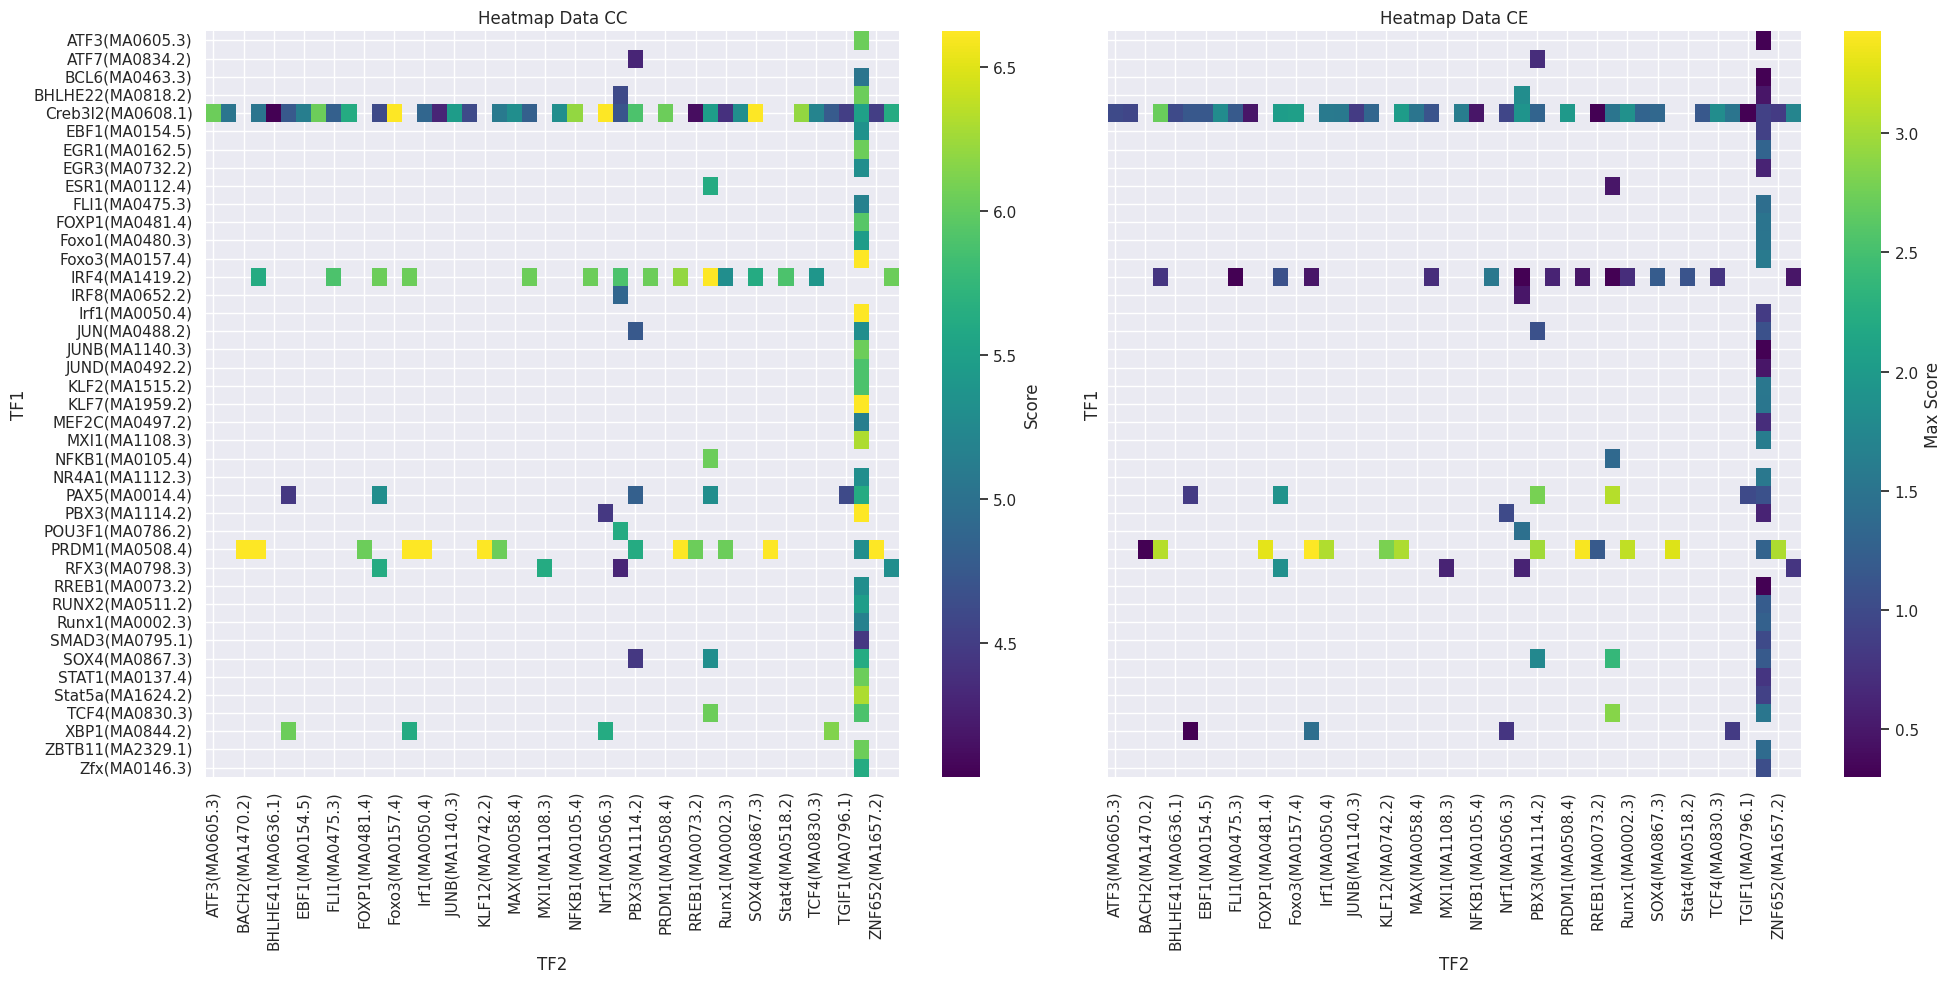

In [142]:


# Plot heatmap_data_cc
sns.heatmap(heatmap_data_cc, ax=axes[0], cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': 'Score'})
axes[0].set_title('Heatmap Data CC')
axes[0].set_xlabel('TF2')
axes[0].set_ylabel('TF1')

# Plot heatmap_data
sns.heatmap(heatmap_data_logged, ax=axes[1], cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': 'Max Score'})
axes[1].set_title('Heatmap Data CE')
axes[1].set_xlabel('TF2')
axes[1].set_ylabel('TF1')
plt.tight_layout()
plt.savefig(f"{out_path}/figures/comparision_heatmap.svg", format='svg')
plt.show()

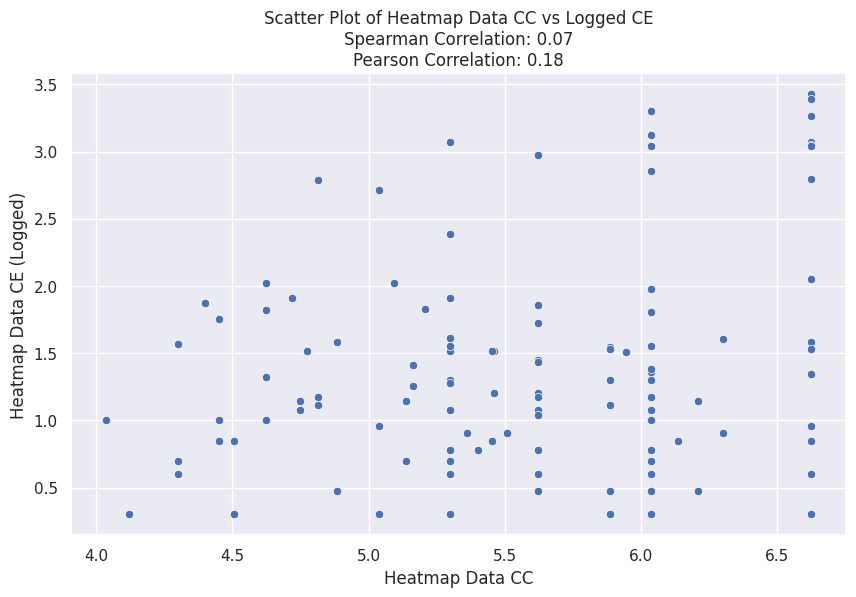

In [141]:
from scipy.stats import spearmanr, pearsonr

# Flatten the heatmap data to create 1D arrays for scatter plotting and correlation
data_cc_flat = heatmap_data_cc.values.flatten()
data_logged_flat = heatmap_data_logged.values.flatten()

# Remove NaN values from both arrays to ensure a proper comparison
mask = ~np.isnan(data_cc_flat) & ~np.isnan(data_logged_flat)
data_cc_flat = data_cc_flat[mask]
data_logged_flat = data_logged_flat[mask]

# Calculate Spearman correlation
spearman_corr, sp_p_value = spearmanr(data_cc_flat, data_logged_flat)
pearson_corr, p_p_value = pearsonr(data_cc_flat, data_logged_flat)
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_cc_flat, y=data_logged_flat)
plt.title(f'Scatter Plot of Heatmap Data CC vs Logged CE\nSpearman Correlation: {spearman_corr:.2f}\nPearson Correlation: {pearson_corr:.2f}')
plt.xlabel('Heatmap Data CC')
plt.ylabel('Heatmap Data CE (Logged)')
plt.savefig(f"{out_path}/figures/correlation_scatter_plot.svg", format='svg')
plt.show()

# CESeek Plots

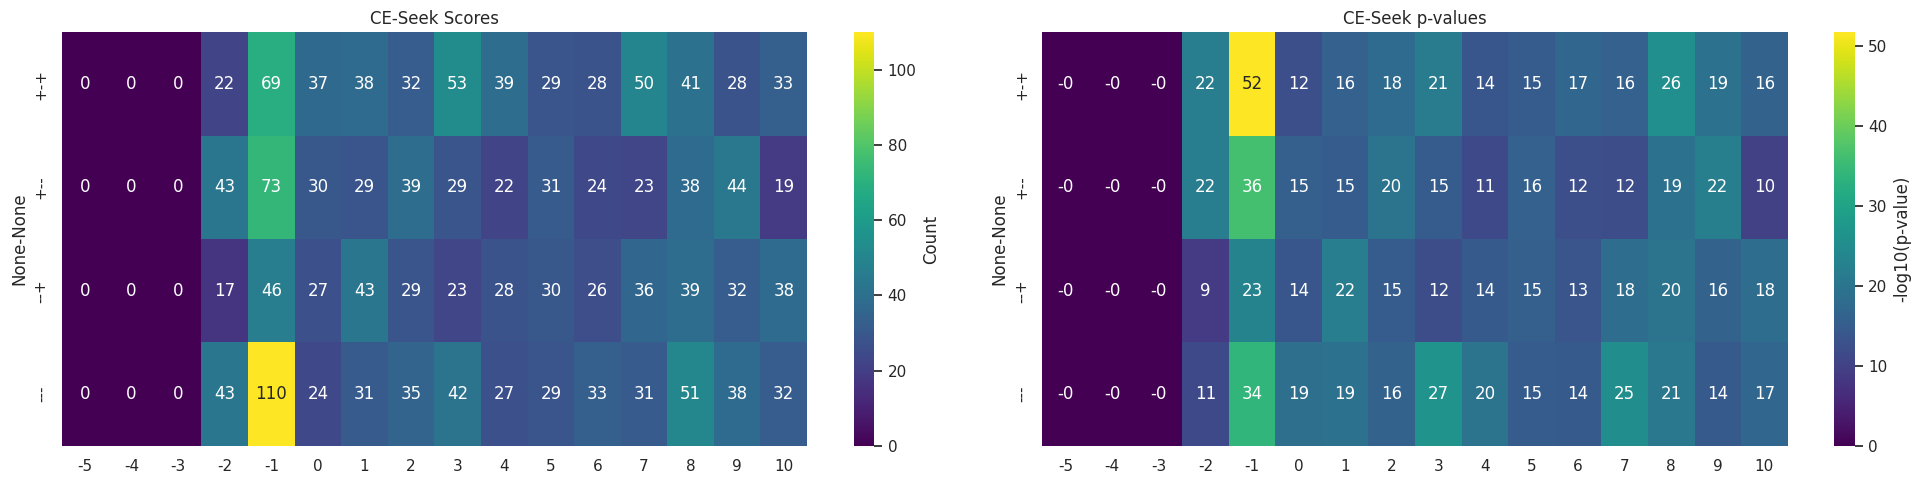

In [46]:
# Plotting scores and p-values in a heatmap
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(ce_seek_score_df, ax=ax[0], cmap='viridis', annot=True, fmt='d', cbar_kws={'label': 'Count'})
ax[0].set_title('CE-Seek Scores')
sns.heatmap(ce_seek_pval_df, ax=ax[1], cmap='viridis', annot=True, cbar_kws={'label': '-log10(p-value)'})
ax[1].set_title('CE-Seek p-values')
plt.tight_layout()
plt.savefig(f"{out_path}/figures/CE-Seek_scores_pvalues.svg")

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

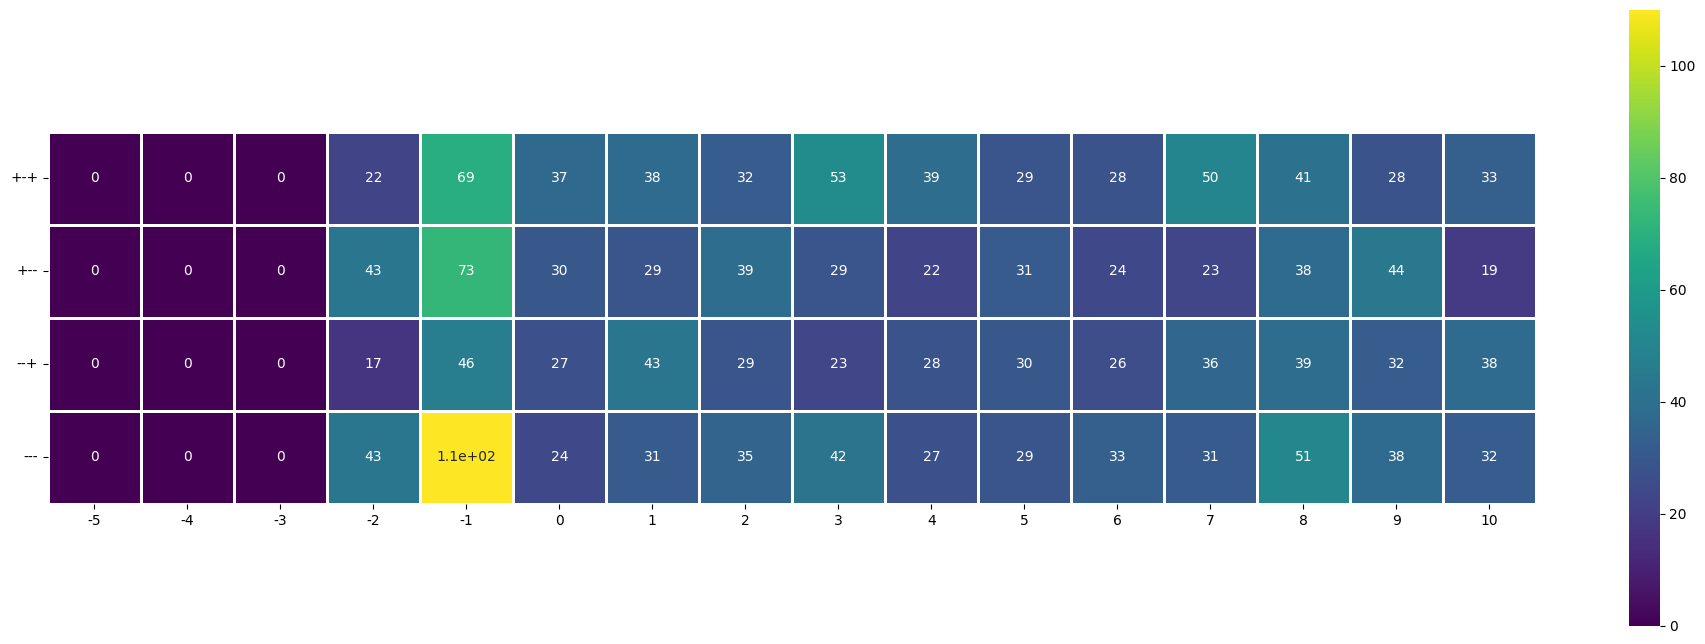

In [35]:
#scan orientiaion and spacing

ce_name = "prdm1_irf"

preferred_motif_set_name=('Nfatc1(MA0624.3)', 'JUN(MA0488.2)')

dict_temp =CEseek_obj.count_CE_configuration_for_motif_pair(*preferred_motif_set_name)

fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')
# df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T.applymap(lambda x: -np.log10(x))

df_plot=pd.DataFrame(dict_temp[list(dict_temp.keys())[0]]).sort_index().T

fig = sns.heatmap(df_plot, 
#                    center=0, 
#                    cmap="vlag",
                   cmap="viridis",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )

fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
sns.set(font_scale=1)
plt.yticks(rotation=0) 



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '+-+'),
  Text(0, 1.5, '+--'),
  Text(0, 2.5, '--+'),
  Text(0, 3.5, '---')])

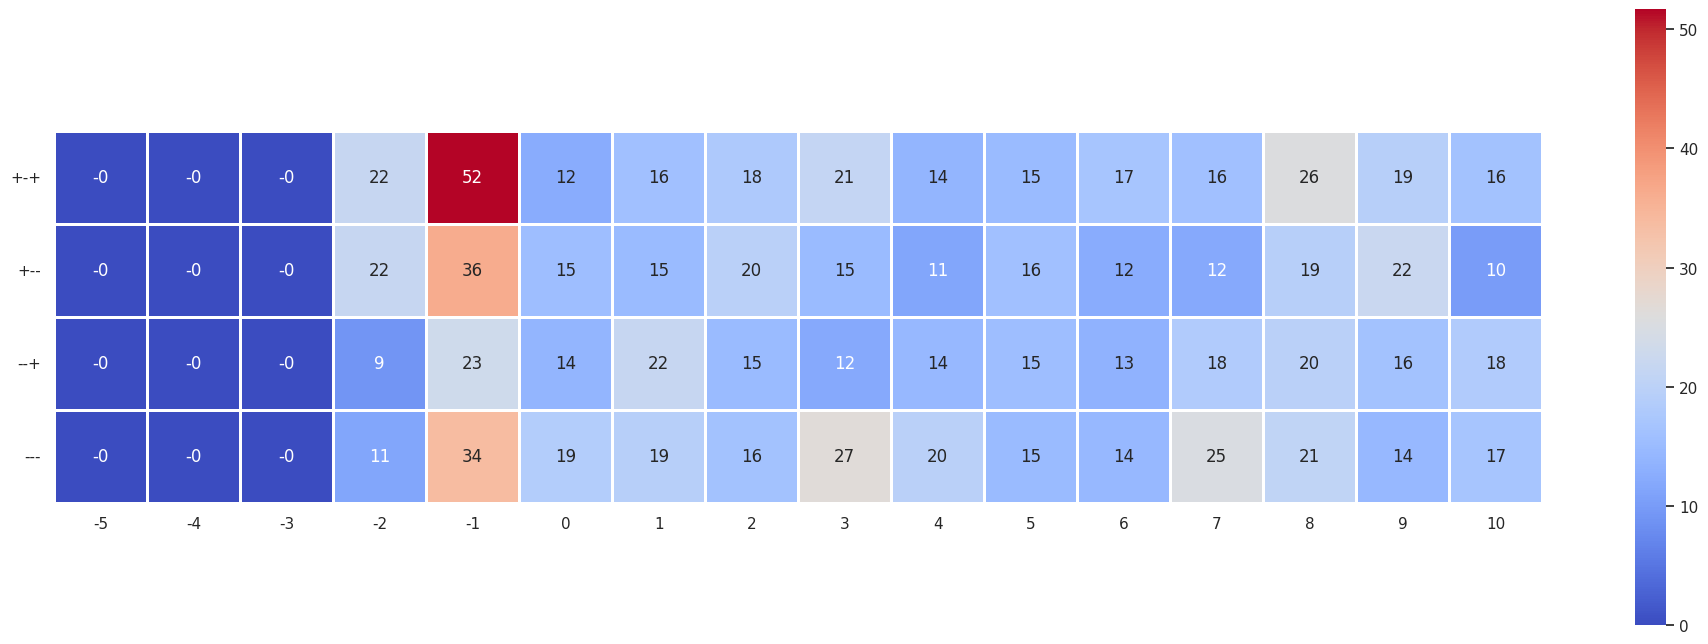

In [47]:
dict_temp=OrderedDict()
dict_temp[preferred_motif_set_name] = OrderedDict()
for strand1 in ["+", "-"]:
    for strand2 in ["+", "-"]:
        key = (strand1, strand2)
        dict_temp[preferred_motif_set_name][key] = {}
for strand1 in ["+", "-"]:
    for strand2 in ["+", "-"]:
        for spacing in range(-5,10+1):
            key = (strand1, strand2)
            p_value=CEseek_obj.motif_enrichment(*preferred_motif_set_name, strand1=strand1, strand2=strand2, spacing=spacing)
            dict_temp[preferred_motif_set_name][key][spacing] = -np.log10(p_value)
df_plot=pd.DataFrame(dict_temp[preferred_motif_set_name]).sort_index().T


fig=plt.figure(figsize=(24,8) , 
#                dpi= 300, 
               facecolor='w', edgecolor='k')

fig = sns.heatmap(df_plot,
#                    center=0,
#                    cmap="vlag",
                   cmap="coolwarm",
#                    vmin=-1,
                   annot=True,
                square=True,
                   linewidths=.75, )
fig.set(xlabel="", ylabel="")
# fig.xaxis.tick_top()
fig.tick_params(top=False)
#         sns.set(font_scale=2)
plt.yticks(rotation=0)

# Saving

## As homer array

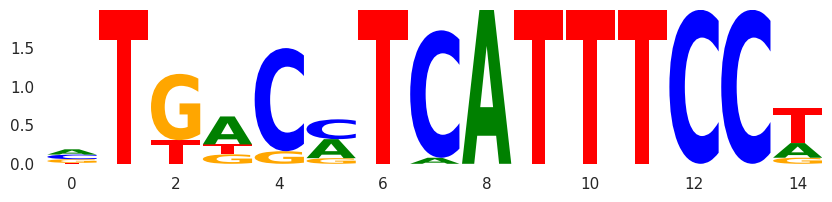

In [23]:
ce_name = "eice"
motif_a = 'Nfatc1(MA0624.3)'
motib_b = 'JUN(MA0488.2)'
strand_a = "+"
strand_b = "+"
spacing = -1
ce_full_name = ce_name + "_" + strand_a + "_" + strand_b + "_" + str(spacing)

sns.set_theme(style="white", palette=None)
pwm=CEseek_obj.generate_pwm(motif_a, motib_b, strand_a, strand_b, spacing)
logo=CEseek_obj.plot_motif(pwm)

# Output file path
# output_file_path = f"{pfm_dir}/{ce_full_name}.motif"

# # Save the motif array to file
# save_motif_to_file(pwm, ce_full_name, output_file_path)

## As bed file

In [ ]:
df = pd.read_csv("/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/%s_%s_%s_%s.txt" % (ce_name, strand_a, strand_b, spacing), sep="\t")
#bed file generation
#chrom, start_CE, end_CE, if strand = "." then follow (+ if CE_orientation = same, or - if CE_orientiation = complement); if strand = 
df = pd.DataFrame(df)

,chrom,start,end,CE_sequence,seq_info,strand
0,chr1,2255789,2255804,CTGACCTCATTTCCT,chr1:2255371-2256406(),NaN
1,chr1,2255823,2255838,CTGACCTCATTTCCT,chr1:2255371-2256406(),NaN
2,chr1,2255891,2255906,CTGACCTCATTTCCT,chr1:2255371-2256406(),NaN
3,chr1,2255917,2255932,GTGACCTCATTTCCT,chr1:2255371-2256406(),NaN
4,chr1,2255949,2255964,CTGACCTCATTTCCT,chr1:2255371-2256406(),NaN
...,...,...,...,...,...,...
105,chr9,14585785,14585800,CTTACATCATTTCCA,chr9:14585475-14586381(),NaN
106,chr9,92821281,92821296,GTTTCCTCATTTCCA,chr9:92820846-92821659(),NaN
107,chr9,114895061,114895076,ATTTCATCATTTCCT,chr9:114894654-114895457(),NaN
108,chrX,2898148,2898163,CTTGCATCATTTCCT,chrX:2897653-2898581(),NaN


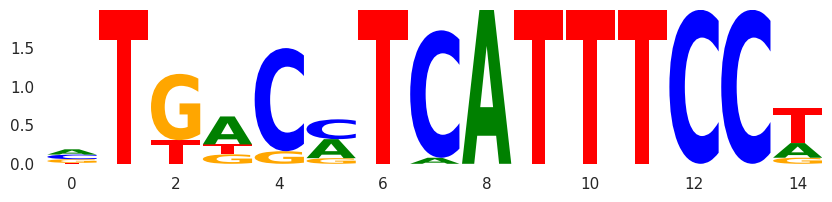

In [24]:
ce_name = "aice"
motif_a = "Nfatc1(MA0624.3)"
motib_b = "JUN(MA0488.2)"
strand_a = "+"
strand_b = "+"
spacing = -1

sns.set_theme(style="white", palette=None)
pwm=CEseek_obj.generate_pwm(motif_a, motib_b, strand_a, strand_b, spacing)
logo=CEseek_obj.plot_motif(pwm)
logo.fig.savefig("/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/%s_%s_%s_%s.pdf" % (ce_name, strand_a, strand_b, spacing))

#get sequences and coordinates of CEs in peaks of interest
CEseek_obj.extract_CE_sequences(motif_a, motib_b, strand_a, strand_b, spacing, 
                                outfile="/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/%s_%s_%s_%s.txt" % (ce_name, strand_a, strand_b, spacing))

df = pd.read_csv("/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/%s_%s_%s_%s.txt" % (ce_name, strand_a, strand_b, spacing), sep="\t")
#bed file generation
#chrom, start_CE, end_CE, if strand = "." then follow (+ if CE_orientation = same, or - if CE_orientiation = complement); if strand = 
df = pd.DataFrame(df)

# Apply the conversion function to the strand column
df['strand'] = df.apply(convert_strand, axis=1)


#convert to bed file format and save
# Subset the DataFrame by selecting specific columns
df_subset = df[['chrom', 'start_CE', 'end_CE', 'CE_sequence', 'seq_info', 'strand']]
# Rename columns 'start_CE' to 'start' and 'end_CE' to 'end'
df_subset = df_subset.rename(columns={'start_CE': 'start', 'end_CE': 'end'})
# Save the DataFrame as a BED file (tab-separated without header and index)
df_subset.to_csv("/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/out_data/ce_seek/out_files/%s_%s_%s_%s.bed" % (ce_name, strand_a, strand_b, spacing), sep='\t', header=False, index=False)
df_subset